##### The original coefficient matrix from polynomial measurement model and its partial derivative on coordinate (x, y) shall be provided

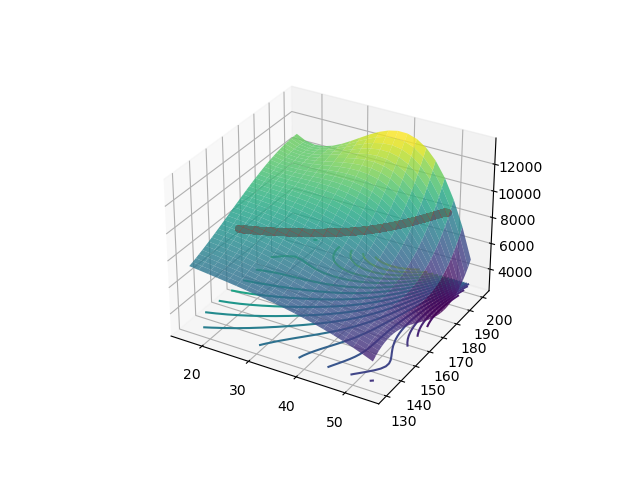

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# basic configuration

arc_length = 79     # unit: mm, from magnet to root (3.5 mm) then to tip (75.5 mm)
step_size = 0.01    # Smaller step size for finer control
start_position = (50, 196)      # It supposed to be 50 if no magnet motion happened on whisker base, but obviously it is not possible
                                # whisker base root hight (196 mm) under current frame

coeff = np.array([ 1.41291644e+01,  6.84458789e+02, -8.54356236e+00,  2.89554635e-02,
        1.47548928e+01, -7.94652582e+01,  1.08592171e+00, -3.68917790e-03,
        2.76873097e+02, -2.43769432e+00, -6.16040281e-03,  6.63353581e-05,
       -6.81630536e+00,  1.00910943e-01, -4.11255374e-04,  2.81628143e-07])     # cofficient matrix of 5 order bivariate polynomial model

# Dyx: start point suppose to be quite hard to define, since the base rotate and linear translate. A FEA could be introduced to analyze the magnet movement.

def calculate_startpoint(z, h):
    """ Calculate the start point on the polynomial surface with given y coordinate and measurement. """
    
    x = sp.symbols('x')
    polynomial = 2.81628142890247e-7*x**3*h**3 - 0.000411255373770958*x**3*h**2 + 0.100910942547882*x**3*h - 6.81630535794003*x**3 + 6.63353581448845e-5*x**2*h**3 - 0.00616040280661882*x**2*h**2 - 2.4376943194328*x**2*h + 276.87309662576*x**2 - 0.00368917790303178*x*h**3 + 1.08592170689341*x*h**2 - 79.4652582182248*x*h + 14.7548927606983*x + 0.0289554635466908*h**3 - 8.5435623649492*h**2 + 684.458789414091*h + 14.129164359912 - z
    x_solution = sp.solveset(polynomial, x, domain=sp.S.Reals)
    return [sol for sol in x_solution if sol >= 0 and sol <= 50]

def z_polyval(x, y, coeff):
    """ Function representing the surface z = f(x, y). """
    
    return np.polynomial.polynomial.polyval2d(x, y, coeff.reshape((4, 4)))

def gradient_z(x, y):
    """ Gradient of the function f(x, y). """ 
    
    dzdx = 8.44884428670741e-7*x**2*y**3 - 0.00123376612131287*x**2*y**2 + 0.302732827643646*x**2*y - 20.4489160738201*x**2 + 0.000132670716289769*x*y**3 - 0.0123208056132376*x*y**2 - 4.8753886388656*x*y + 553.746193251521*x - 0.00368917790303178*y**3 + 1.08592170689341*y**2 - 79.4652582182248*y + 14.7548927606983
    dzdy = 8.44884428670741e-7*x**3*y**2 - 0.000822510747541916*x**3*y + 0.100910942547882*x**3 + 0.000199006074434653*x**2*y**2 - 0.0123208056132376*x**2*y - 2.4376943194328*x**2 - 0.0110675337090953*x*y**2 + 2.17184341378682*x*y - 79.4652582182248*x + 0.0868663906400725*y**2 - 17.0871247298984*y + 684.458789414091
    return np.array([dzdx, dzdy], dtype=np.float64)

def loss_gradient_z(x, y, target_z):
    """ Gradient of the squared error loss function. """
    
    error = z_polyval(x, y, coeff) - target_z
    grad_z = gradient_z(x, y)
    return 2 * error * grad_z

def titap_contact_est_gradientdescent(target_z, start_x, start_y, step_size, arc_length):    # only variable here : target_z - sampled data from sensor
    """ Performs constrained gradient descent to move along a level curve, adjusting by loss. """
    
    # Initialize the start position, path and arc distance
    # x = float(calculate_startpoint(target_z, start_hight)[0])
    x = start_x
    y = start_y
    path = [(x, y)]     # Just delete this variable and return (x, y) if you only need the contact position 
    delta_dis = 0
    
    while True and delta_dis <= arc_length:
        
        grad_loss = loss_gradient_z(x, y, target_z)
        # Move in direction that minimizes the loss, correcting direction
        loss_direction = np.array([grad_loss[0], grad_loss[1]])
        loss_direction /= np.linalg.norm(loss_direction) # Normalize to step size
        
        grad_tangent = gradient_z(x, y)
        # Move in direction perpendicular to gradient: Rotate gradient by 90 degrees
        tangent_direction = np.array([-grad_tangent[1], grad_tangent[0]])
        tangent_direction /= np.linalg.norm(tangent_direction) # Normalize to step size
        
        dx = step_size * (tangent_direction[0] - loss_direction[0])
        dy = step_size * (tangent_direction[1] - loss_direction[1])
        delta_dis += np.sqrt(dx**2 + dy**2)
        
        x += dx
        y += dy
        
        path.append((x, y)) 
        
    return np.array(path)

# Implementation
    
arc = titap_contact_est_gradientdescent(target_z=8536.9998, 
                                    start_x=start_position[0], 
                                    start_y=start_position[1],
                                    step_size=step_size, 
                                    arc_length=arc_length)

%matplotlib widget

x = np.linspace(16, 54, 20)
y = np.linspace(130, 200, 36)

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Plot surface
surface = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((4, 4)))
surf = ax.plot_surface(X, Y, surface.T, cmap="viridis", alpha=0.8)

# Plot contour lines on the surface
num_levels = 20
contour_levels = np.linspace(np.min(surface), np.max(surface), num_levels)
contour_surf = ax.contour(X, Y, surface.T, levels=contour_levels, offset=np.min(surface), cmap='viridis')

zs = np.full(arc.shape[0], 8536.9998)
ax.scatter(arc[:, 0], arc[:, 1], zs, color='r')

plt.show()

### Imp

In [2]:
def titap_contact_est(target_z, start_x, start_y, step_size, arc_length):    # only variable here : target_z - sampled data from sensor
    """ Performs constrained gradient descent to move along a level curve, adjusting by loss. """
    
    # Initialize the start position, path and arc distance
    # x = float(calculate_startpoint(target_z, start_hight)[0])
    x = start_x
    y = start_y
    # path = [(x, y)]     # Just delete this variable and return (x, y) if you only need the contact position 
    delta_dis = 0
    
    while True and delta_dis <= arc_length:
        
        grad_loss = loss_gradient_z(x, y, target_z)
        # Move in direction that minimizes the loss, correcting direction
        loss_direction = np.array([grad_loss[0], grad_loss[1]])
        loss_direction /= np.linalg.norm(loss_direction) # Normalize to step size
        
        grad_tangent = gradient_z(x, y)
        # Move in direction perpendicular to gradient: Rotate gradient by 90 degrees
        tangent_direction = np.array([-grad_tangent[1], grad_tangent[0]])
        tangent_direction /= np.linalg.norm(tangent_direction) # Normalize to step size
        
        dx = step_size * (tangent_direction[0] - loss_direction[0])
        dy = step_size * (tangent_direction[1] - loss_direction[1])
        delta_dis += np.sqrt(dx**2 + dy**2)
        
        x += dx
        y += dy
        
        # path.append((x, y)) 
        
    return (x, y)

In [3]:
titap_contact_est(8536.9998, 
                  start_x=start_position[0], 
                  start_y=start_position[1],
                  step_size=step_size, 
                  arc_length=arc_length)

(19.388679979409975, 150.74901524177835)

### Data Pre-processing

In [4]:
import pandas as pd

# Data format : 
#           timestamp，
#           magnetic_x, magnetic_y, magnetic_z, 
#           lv_x, lv_y, lv_z, av_x, av_y. av_z

trajectory_df = pd.read_csv("Data/Experiments/TipTapTrajectory-1704-3/trajectory.csv")

In [5]:
# delta time : second s

from datetime import datetime

dt_frame = np.array(trajectory_df)[:, 0]

dt = [0]
for i in range(1, dt_frame.shape[0]):
    tr = datetime.fromtimestamp(dt_frame[i])
    tf = datetime.fromtimestamp(dt_frame[i-1])
    dt.append((tr-tf).total_seconds())
dt = np.array(dt)

In [6]:
# linear- and angular-veolocity : mm/s & rad/s 

# This is a normal velocity setting for plane and fixed contact point situation. The contact motion should be quite predictable
linear_vel = np.array([-np.array(trajectory_df)[:, 5], -np.array(trajectory_df)[:, 6], np.array(trajectory_df)[:, 4]]) * 1e3
angular_vel = np.array([np.array(trajectory_df)[:, 7], np.array(trajectory_df)[:, 8], np.array(trajectory_df)[:, 9]])

us = np.append(linear_vel, angular_vel, axis=0).T

In [7]:
# Measurements Update : 
zs = [np.array([np.array(trajectory_df)[i, 2]]) for i in range(trajectory_df.shape[0])]

In [8]:
zs

[array([6083.44775391]),
 array([6093.63964844]),
 array([6083.44775391]),
 array([6081.87988281]),
 array([6092.46386719]),
 array([6088.93603516]),
 array([6090.11181641]),
 array([6096.38378906]),
 array([6097.56005859]),
 array([6086.97607422]),
 array([6114.02392578]),
 array([6092.07177734]),
 array([6108.14404297]),
 array([6104.61572266]),
 array([6108.92773438]),
 array([6116.76806641]),
 array([6123.04003906]),
 array([6108.92773438]),
 array([6104.61572266]),
 array([6127.74365234]),
 array([6121.08007812]),
 array([6127.35205078]),
 array([6124.60791016]),
 array([6122.25585938]),
 array([6129.31201172]),
 array([6136.75976562]),
 array([6127.74365234]),
 array([6133.23193359]),
 array([6143.81591797]),
 array([6144.59960938]),
 array([6143.03173828]),
 array([6142.63964844]),
 array([6143.81591797]),
 array([6133.62402344]),
 array([6152.04785156]),
 array([6157.92773438]),
 array([6152.04785156]),
 array([6148.91162109]),
 array([6163.02392578]),
 array([6168.11962891]),


### Test

In [9]:
end_points = []

for _ in range(len(zs)):
    temp = titap_contact_est(target_z=zs[_], 
                             start_x=start_position[0], 
                             start_y=start_position[1], 
                             step_size=step_size, 
                             arc_length=arc_length)
    end_points.append(temp)
    print(_)

end_points = np.array(end_points)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


KeyboardInterrupt: 

In [ ]:
end_points_ = []
displacement = np.array([0. ,0. ,0.]) # overall position displacement from first iteration

for _ in range(end_points_.shape[0]):
    displacement += np.dot(us[_][:3], dt[_])
    temp = end_points[_] + displacement
    end_points_.append(temp)
end_points_ = np.array(end_points_)

In [ ]:
end_points_.shape

In [ ]:
from ipywidgets import interact
from kf_book.book_plots import IntSlider

print(end_points_)

def interactive_estimatesonbase_dynamic(iter):

    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure(figsize=(10, 6))

    plt.grid()
    plt.ylim([0, 175])
    plt.xlim([0, 100])
    plt.plot(end_points_[:iter, 0], end_points_[:iter, 1], label='Estimated Trajectory')
    plt.scatter(end_points_[iter-1, 0], end_points_[iter-1, 1], marker='o', c='#d62728')
    plt.show()

interact(interactive_estimatesonbase_dynamic, iter=IntSlider(value=1, min=0, max=end_points.shape[0]))